In [5]:
import numpy as np 
import csv
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = np.load('pems08.npz')

In [3]:
traffic_data = data['data']
print(f"Shape of the data: {traffic_data.shape}")

print(traffic_data[0:2]) 

Shape of the data: (17856, 170, 3)
[[[1.330e+02 6.030e-02 6.580e+01]
  [2.100e+02 5.890e-02 6.960e+01]
  [1.240e+02 3.580e-02 6.580e+01]
  ...
  [7.400e+01 2.131e-01 6.530e+01]
  [9.400e+01 2.260e-02 6.800e+01]
  [6.000e+00 3.100e-03 6.500e+01]]

 [[1.140e+02 5.320e-02 6.690e+01]
  [1.850e+02 5.500e-02 6.850e+01]
  [1.190e+02 3.390e-02 6.500e+01]
  ...
  [7.300e+01 1.469e-01 3.720e+01]
  [8.400e+01 1.890e-02 6.870e+01]
  [4.000e+00 1.800e-03 6.500e+01]]]


In [4]:
missing_values = np.isnan(traffic_data).sum()
print(f"Missing values: {missing_values}")

Missing values: 0


In [5]:
# Define the starting date and time
start_datetime = datetime(2016, 7, 1, 0, 0)

with open('traffic_data_with_datetime.csv', 'w') as file:
    file.write('datetime,location,flow,occupy,speed\n')
    
    for timestep in range(traffic_data.shape[0]):
        # Calculate the current datetime for the timestep
        current_datetime = start_datetime + timedelta(minutes=5 * timestep)
        formatted_datetime = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
        
        for location in range(traffic_data.shape[1]):
            flow, occupancy, speed = traffic_data[timestep, location]
            
            # Write the datetime instead of timestep
            file.write(f'{formatted_datetime},{location},{flow},{occupancy},{speed}\n')

print("traffic_data_with_datetime.csv")


traffic_data_with_datetime.csv


In [4]:
x = pd.read_csv('traffic_data_5min_intervals.csv')
print(x.shape)

(3035520, 5)


In [ ]:
input_csv = 'traffic_data_with_datetime.csv'
output_csv = 'traffic_2hr_intervals.csv'

location_no = 170  # Total number of locations
interval_minutes = 120  # 2 hours in minutes
aggregation_steps = interval_minutes // 5  # Number of 5-minute steps in 2 hours

with open(output_csv, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['datetime', 'location', 'flow', 'occupy', 'speed'])

    with open(input_csv, 'r') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip the header

        timestep_2hr = None
        location_data = np.zeros((location_no, 3))  # To store flow, occupancy, and speed
        count = 0  # Track number of 5-min steps processed in the current 2-hr interval

        for row in reader:
            datetime_str = row[0]
            location = int(row[1])
            flow = float(row[2])
            occupy = float(row[3])
            speed = float(row[4])

            # Parse the current datetime
            current_datetime = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

            if timestep_2hr is None:
                timestep_2hr = current_datetime

            # Accumulate data for the current location
            location_data[location, 0] += flow
            location_data[location, 1] += occupy
            location_data[location, 2] += speed
            count += 1

            # When a 2-hour interval is complete
            if count == location_no * aggregation_steps:
                for loc in range(location_no):
                    mean_flow = location_data[loc, 0] / aggregation_steps
                    mean_occupy = location_data[loc, 1] / aggregation_steps
                    mean_speed = location_data[loc, 2] / aggregation_steps

                    writer.writerow([timestep_2hr.strftime('%Y-%m-%d %H:%M:%S'), loc, mean_flow, mean_occupy, mean_speed])

                # Reset for the next interval
                timestep_2hr += timedelta(minutes=interval_minutes)
                location_data.fill(0)
                count = 0
                
                
print(output_csv)

In [6]:
df = pd.read_csv('traffic_2hr_intervals.csv')

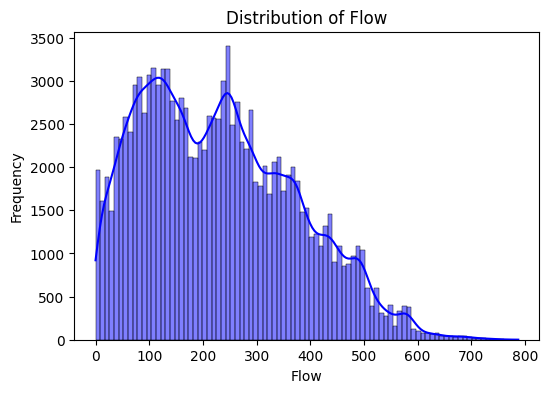

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(df['flow'], kde=True, color='blue')
plt.title('Distribution of Flow')
plt.xlabel('Flow')
plt.ylabel('Frequency')
plt.show()

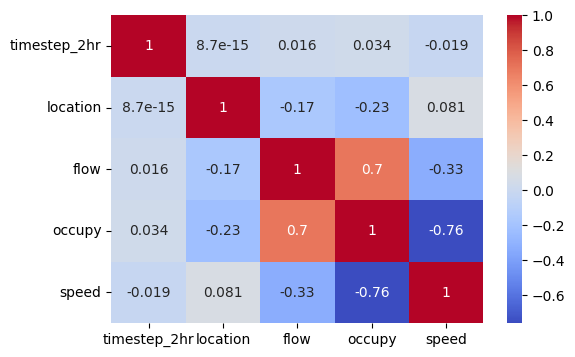

In [9]:
x = pd.read_csv('traffic.csv')

cor = x.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.show()

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of labels (744).

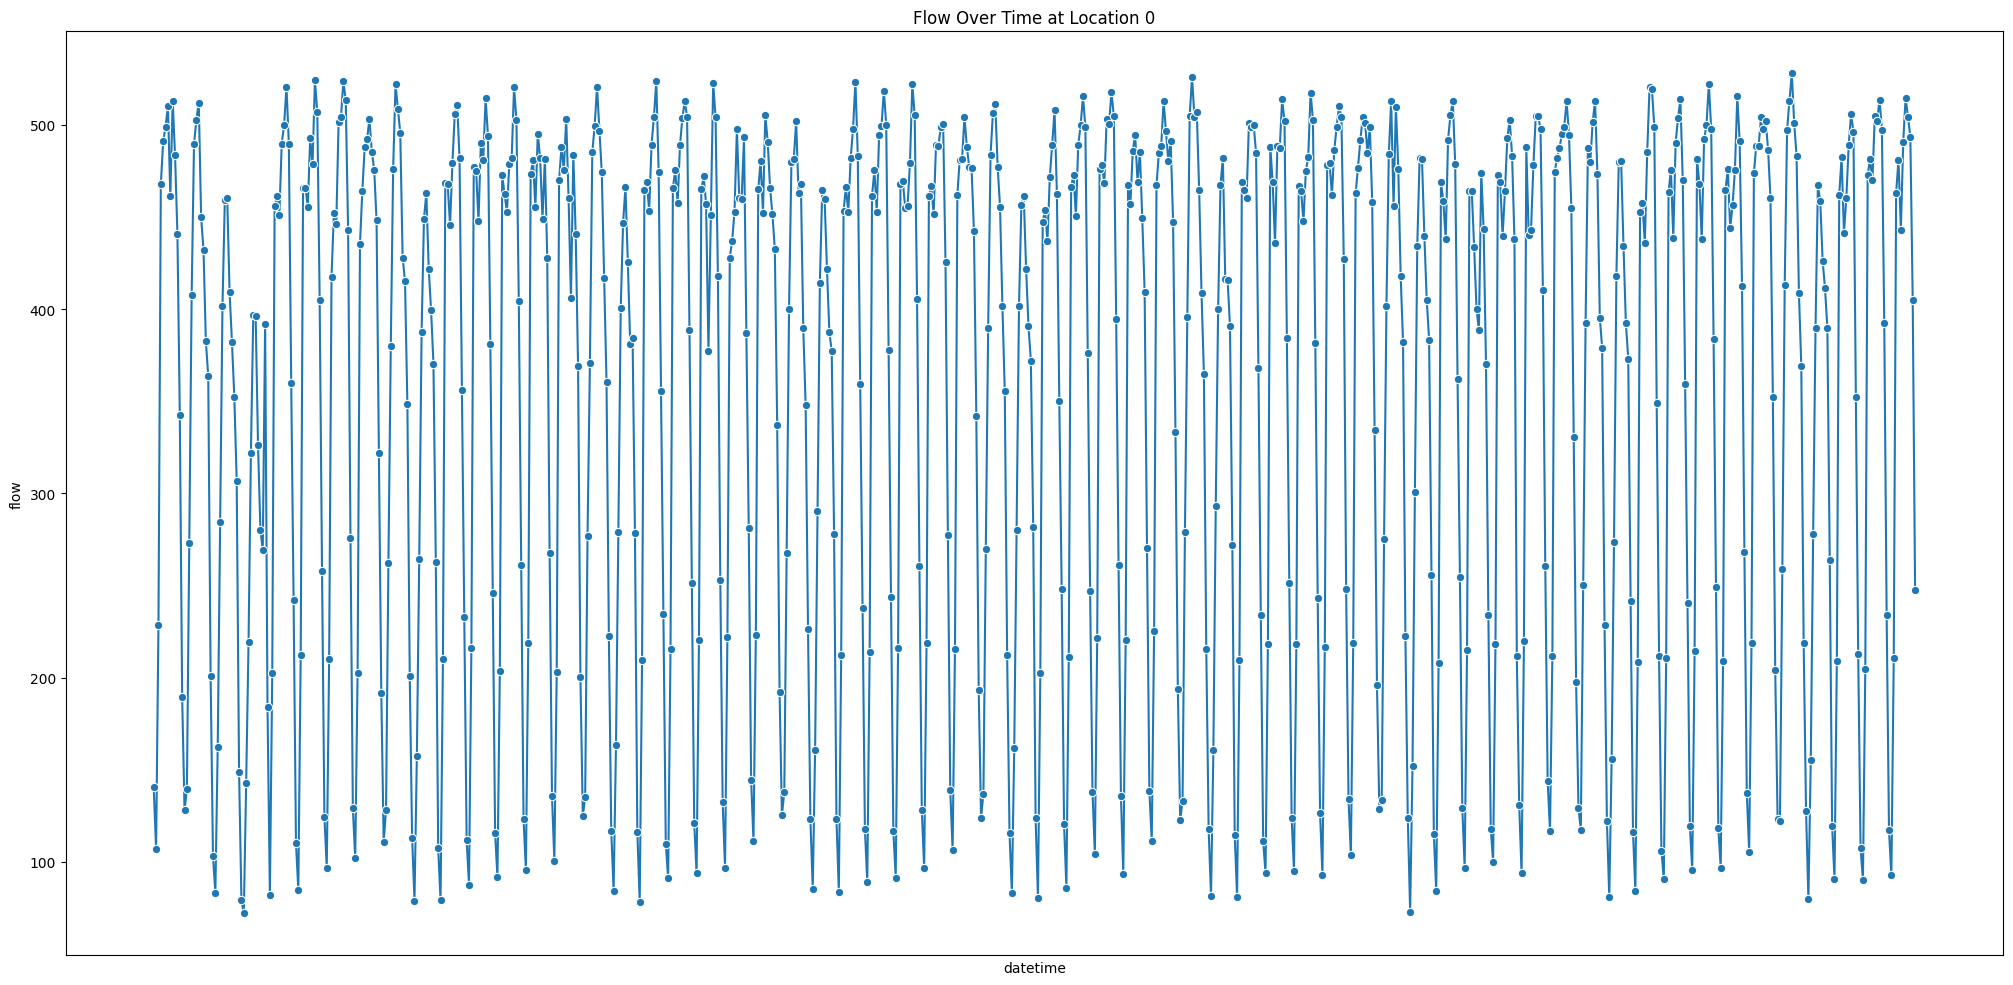

In [16]:
loc = df[df['location'] == 1]

plt.figure(figsize=(25, 12))
sns.lineplot(x='datetime', y='flow', data=loc, marker='o')
plt.title(f'Flow Over Time at Location 0')
plt.xticks(ticks=range(len(loc), 10), labels=loc['datetime'])
plt.xlabel('Time')
plt.ylabel('Flow')
plt.grid(True)
plt.show()